# Imports, Setup, Dataset

In [329]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
import matplotlib
from collections import Counter
from pprint import pprint
import matplotlib.colors as mcolors
import matplotlib.collections as mcollections

In [330]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
prices_df.index = pd.to_datetime(prices_df.index)
caps_df = pd.read_csv(cap_path, index_col='date')
caps_df.index = pd.to_datetime(caps_df.index)

In [331]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [332]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10810
2467


In [333]:
train_df = train_df[non_null_stocks]

# Sectors

In [334]:
Market_dict = {}

In [335]:
file_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/Nasdaq_sectors.csv'
nasdaq_sectors = pd.read_csv(file_path)
#nasdaq_sectors.head()
cols_to_keep = ['Symbol', 'Sector']
nasdaq_sectors = nasdaq_sectors[cols_to_keep]

In [336]:
for Sector in nasdaq_sectors['Sector'].unique().tolist():
    if pd.notna(Sector):
        Market_dict[Sector] = []
        temp_df = nasdaq_sectors[nasdaq_sectors['Sector']==Sector]
        for stk in temp_df['Symbol'].unique().tolist():
            if stk in non_null_stocks:
                Market_dict[Sector].append(stk)

In [337]:
caps_df = caps_df[non_null_stocks]

In [338]:
for Sector in list(Market_dict.keys()):
    print(Sector)
    print(len(Market_dict[Sector]))

Industrials
202
Finance
186
Real Estate
42
Health Care
124
Consumer Discretionary
275
Technology
139
Basic Materials
13
Consumer Staples
40
Energy
47
Miscellaneous
9
Utilities
43
Telecommunications
14


In [339]:
full_market_dict = Market_dict

In [340]:
top_stocks = {}
for Sector in list(Market_dict.keys()):
    Sector_stocks = Market_dict[Sector]
    Sector_df = caps_df[Sector_stocks]
    top_10_stocks = list(Sector_df.mean().nlargest(10).index)
    top_stocks[Sector] = top_10_stocks

In [341]:
low_var_stocks = {}
for Sector in list(top_stocks.keys()):
    low_var_stocks[Sector] = []
    sector_stocks_variance = {}
    for stk in top_stocks[Sector]:
        # find the cv
        std_dev = float(np.std(train_df[stk]))
        mean = float(np.mean(train_df[stk]))
        cv = std_dev/mean
        sector_stocks_variance[stk] = cv
    top_4 = sorted(sector_stocks_variance.items(), key=lambda x: x[1])[:6]
    for stk_tpl in top_4:
        stk_name = stk_tpl[0]
        low_var_stocks[Sector].append(stk_name)
low_var_stocks

{'Industrials': ['UPS', 'HON', 'BA', 'LMT', 'TMO', 'UNP'],
 'Finance': ['TRV', 'AXP', 'MMC', 'AON', 'CB', 'SPGI'],
 'Real Estate': ['LAMR', 'IRM', 'HST', 'CPT', 'UDR', 'EQR'],
 'Health Care': ['MDT', 'AMGN', 'JNJ', 'ABT', 'LLY', 'MRK'],
 'Consumer Discretionary': ['WMT', 'HD', 'LOW', 'PG', 'COST', 'SBUX'],
 'Technology': ['MSFT', 'IBM', 'QCOM', 'INTC', 'ORCL', 'NVDA'],
 'Basic Materials': ['IP', 'NEM', 'AMWD', 'TREX', 'UFPI', 'LPX'],
 'Consumer Staples': ['WBA', 'KR', 'KO', 'PEP', 'HSY', 'GIS'],
 'Energy': ['XOM', 'CVX', 'COP', 'HAL', 'SLB', 'DVN'],
 'Miscellaneous': ['SPB', 'VYX', 'IDCC', 'ULBI', 'NVRI', 'NOVT'],
 'Utilities': ['WM', 'ED', 'XEL', 'FE', 'PEG', 'PPL'],
 'Telecommunications': ['LUMN', 'MATW', 'ESE', 'SHEN', 'CSCO', 'ZD']}

In [342]:
Sector_order = [
    "Technology", "Health Care", "Energy", "Industrials", "Basic Materials", 
    "Consumer Staples", "Consumer Discretionary", "Telecommunications", 
    "Finance", "Utilities", "Real Estate"
]

Sector_order_dict = {}
for i in range(10):
    sectors = Sector_order[:(i+2)]
    Sector_order_dict[f'{str(i+2)}'] = sectors

Manual_dict = {}
for num_sectors in list(Sector_order_dict.keys()):
    combined_list = []
    for sector in Sector_order_dict[num_sectors]:
        combined_list += low_var_stocks[sector]
    Manual_dict[num_sectors] = combined_list

# Functions

## Clustering

In [343]:
def get_corr_matrix(DataFrame):
    return DataFrame.corr()

In [344]:
def K_mean_cluster_not_given_corr_matrix(DataFrame, num_clusters):
    X = get_corr_matrix(DataFrame)
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [345]:
def spectral_cluster_not_given_corr_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [346]:
def K_mean_cluster_given_corr_matrix(DataFrame, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(DataFrame)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [347]:
def spectral_cluster_given_corr_matrix(df, num_clusters):
    A = abs(df.values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

## Trading

### V1

#### M1: Manual, no clustering, beta for direction

In [348]:
def trading_M1(DataFrame,Sector_Dict, months_to_run):
    #### Setup
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
  
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
            # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
                    
        ### iterate over each sector
        Current_Sectors = {}
        for stk in DataFrame.columns:
            for sector in list(Sector_Dict.keys()):
                if stk in Sector_Dict[sector]:
                    if sector not in list(Current_Sectors.keys()):
                        Current_Sectors[sector] = [stk]
                    else:
                        Current_Sectors[sector].append(stk)
        for sector in list(Current_Sectors.keys()):
            ### look at the sign count
            up_stocks = []
            down_stocks = []
            for stk in Current_Sectors[sector]:
                price_data = DataFrame[stk][first_day:current_last_day]
                covariance = np.cov(range(len(price_data)), price_data.values)
                beta = covariance[0,1]
                if beta > 0:
                    up_stocks.append(stk)
                else:
                    down_stocks.append(stk)
            # if a minority n number of stocks is not following the group, we trade
            if (len(up_stocks)==1) or (len(down_stocks)==1):
                if len(up_stocks) != len(down_stocks): # adjust this in the future to be more specific?...
                    if len(up_stocks) > len(down_stocks):
                        Trade_type = 'Long'
                        minority_stocks = down_stocks
                    else:
                        Trade_type = 'Short'
                        minority_stocks = up_stocks
                    # find the minority stock/s
                    for trading_stock in minority_stocks:
                        # check if the stock exists in trades_dict, otherwise we have to create it
                        current_price = DataFrame.loc[current_last_day, trading_stock]
                        if trading_stock in list(trades_dict.keys()):
                            trades_dict[trading_stock]['Open_date'].append(current_last_day)
                            trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                            trades_dict[trading_stock]['Open_price'].append(current_price)
                        else: 
                            trades_dict[trading_stock] = {
                                'Open_date':[current_last_day],
                                'Close_date':[],
                                'Trade_type':[Trade_type],
                                'Open_price':[current_price],
                                'Close_price':[],
                                'Profit':[],
                            }
                        currently_in_trade.append(trading_stock)

        # move days
        first_day = next_day   

    ### output trading dict
    return trades_dict

#### M2: Manual, clustering, beta for direction

In [349]:
def trading_M2(DataFrame,Sector_Dict, months_to_run, cluster_method, num_clusters):
    #### Setup
    output_data = []
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
                # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster_not_given_corr_matrix(DataFrame[first_day:last_day_of_month], num_clusters)
        else:
            cluster_entry = spectral_cluster_not_given_corr_matrix(DataFrame[first_day:last_day_of_month], num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster+1}_Members'] = cluster_entry[cluster]
            new_row_cluster_majority = 'Null'
            new_row_cluster_trading_stock = 'Null'
            #### Check the composition of the cluster
            clusters_stocks = cluster_entry[cluster]
            # talley the sectors
            cluster_sectors = {}
            for stk in clusters_stocks:
                for sector in list(Sector_Dict.keys()):
                    if stk in Sector_Dict[sector]:
                        if sector in list(cluster_sectors.keys()):
                            cluster_sectors[sector] += 1
                        else:
                            cluster_sectors[sector] = 1
                        break
            missclassified_stock = 'Null'
            if len(list(cluster_sectors.keys())) != 1:
                # Determine if there is a majority or tie
                highest_count = max(cluster_sectors.values())
                majority_sectors = [sector for sector, count in cluster_sectors.items() if count == highest_count]
                if len(majority_sectors) == 1:
                    new_row_cluster_majority = majority_sectors[0]
                    # Determine if there is a minority or tie
                    lowest_count = min(cluster_sectors.values())
                    minority_sectors = [sector for sector, count in cluster_sectors.items() if (count == lowest_count)]
                    if len(minority_sectors) == 1:
                        minority_stocks = []
                        for stk in clusters_stocks:
                            if stk in Sector_Dict[minority_sectors[0]]:
                                minority_stocks.append(stk)
                        if len(minority_stocks) == 1:
                            for stk in clusters_stocks:
                                if missclassified_stock == 'Null':
                                    if stk in Sector_Dict[minority_sectors[0]]:
                                        missclassified_stock = stk
                                        new_row_cluster_trading_stock = stk
                                        break
                                else:
                                    break
            new_row[f'Cluster_{cluster+1}_Majority_Sector'] = new_row_cluster_majority
            new_row[f'Cluster_{cluster+1}_Trading_Stock'] = new_row_cluster_trading_stock
            ### Trading PT 2
            # open up new trades if possible
            if missclassified_stock != 'Null':
                # find the sector:
                trading_stock = missclassified_stock
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in DataFrame.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # Check its peers' behavior
                up_cntr = 0
                down_cntr = 0
                for stk in peer_stocks:
                    price_data = DataFrame[stk][first_day:current_last_day]
                    covariance = np.cov(range(len(price_data)), price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        up_cntr +=1
                    else:
                        down_cntr +=1
                if up_cntr > down_cntr:
                    Trade_type = 'Long'
                elif down_cntr > up_cntr:
                    Trade_type = 'Short'
                else:
                    Trade_type = 'None'
                if Trade_type != 'None':
                    # open the trade & record it
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = DataFrame.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)
        #### Cleanup
        first_day = next_day # Set the first day for the next month
        output_data.append(new_row) # Append the month's row

    #### Output
    df = pd.DataFrame(output_data)
    df.set_index('timestamp', inplace=True)
    return df, trades_dict

#### M3: Manual, clustering, deviations for direction

In [350]:
def trading_M3(DataFrame,Sector_Dict, months_to_run, cluster_method, num_clusters):
    #### Setup
    output_data = []
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
                # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster_not_given_corr_matrix(DataFrame[first_day:last_day_of_month], num_clusters)
        else:
            cluster_entry = spectral_cluster_not_given_corr_matrix(DataFrame[first_day:last_day_of_month], num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster+1}_Members'] = cluster_entry[cluster]
            new_row_cluster_majority = 'Null'
            new_row_cluster_trading_stock = 'Null'
            #### Check the composition of the cluster
            clusters_stocks = cluster_entry[cluster]
            # talley the sectors
            cluster_sectors = {}
            for stk in clusters_stocks:
                for sector in list(Sector_Dict.keys()):
                    if stk in Sector_Dict[sector]:
                        if sector in list(cluster_sectors.keys()):
                            cluster_sectors[sector] += 1
                        else:
                            cluster_sectors[sector] = 1
                        break
            missclassified_stock = 'Null'
            if len(list(cluster_sectors.keys())) != 1:
                # Determine if there is a majority or tie
                highest_count = max(cluster_sectors.values())
                majority_sectors = [sector for sector, count in cluster_sectors.items() if count == highest_count]
                if len(majority_sectors) == 1:
                    new_row_cluster_majority = majority_sectors[0]
                    # Determine if there is a minority or tie
                    lowest_count = min(cluster_sectors.values())
                    minority_sectors = [sector for sector, count in cluster_sectors.items() if (count == lowest_count)]
                    if len(minority_sectors) == 1:
                        minority_stocks = []
                        for stk in clusters_stocks:
                            if stk in Sector_Dict[minority_sectors[0]]:
                                minority_stocks.append(stk)
                        if len(minority_stocks) == 1:
                            for stk in clusters_stocks:
                                if missclassified_stock == 'Null':
                                    if stk in Sector_Dict[minority_sectors[0]]:
                                        missclassified_stock = stk
                                        new_row_cluster_trading_stock = stk
                                        break
                                else:
                                    break
            new_row[f'Cluster_{cluster+1}_Majority_Sector'] = new_row_cluster_majority
            new_row[f'Cluster_{cluster+1}_Trading_Stock'] = new_row_cluster_trading_stock
            ### Trading PT 2
            # open up new trades if possible
            if missclassified_stock != 'Null':
                # find the sector:
                trading_stock = missclassified_stock
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in DataFrame.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # calculate direction based on deviations for peer mean
                peer_prices = []
                for stk in peer_stocks:
                    day_1_price = train_df[stk][first_day]
                    peer_prices.append(day_1_price)
                peer_mean_price = np.mean(peer_prices)
                minority_prices = list(train_df[missclassified_stock][first_day:current_last_day])
                minority_deviations = [x - peer_mean_price for x in minority_prices]
                sum_deviations = np.sum(minority_deviations)
                if sum_deviations < 0:
                    Trade_type = 'Long'
                elif sum_deviations > 0:
                    Trade_type = 'Short'
                else:
                    Trade_type = 'None'
                if Trade_type != 'None':
                    # open the trade & record it
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = DataFrame.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)
        #### Cleanup
        first_day = next_day # Set the first day for the next month
        output_data.append(new_row) # Append the month's row

    #### Output
    df = pd.DataFrame(output_data)
    df.set_index('timestamp', inplace=True)
    return df, trades_dict

#### M4: Randomized, no clustering, beta for direction

In [351]:
# note: in order to be fully random, this should take in full market dict
def trading_M5(DataFrame,Sector_Dict, months_to_run, num_sectors, sector_oder_dict):
    #### Setup
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)

        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
            # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
                    
        ### find what sectors we are using
        Current_Sectors = sector_oder_dict[str(num_sectors)]
        for sector in Current_Sectors:
            ### look at the sign count
            up_stocks = []
            down_stocks = []
            random_stocks = random.sample(Sector_Dict[sector], 4)
            for stk in random_stocks:
                price_data = DataFrame[stk][first_day:current_last_day]
                covariance = np.cov(range(len(price_data)), price_data.values)
                beta = covariance[0,1]
                if beta > 0:
                    up_stocks.append(stk)
                else:
                    down_stocks.append(stk)
            # if a minority n number of stocks is not following the group, we trade
            if len(up_stocks) != len(down_stocks): # adjust this in the future to be more specific?...
                if len(up_stocks) > len(down_stocks):
                    Trade_type = 'Long'
                    minority_stocks = down_stocks
                else:
                    Trade_type = 'Short'
                    minority_stocks = up_stocks
                # find the minority stock/s
                for trading_stock in minority_stocks:
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = DataFrame.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)

        # move days
        first_day = next_day   

    ### output trading dict
    return trades_dict

### V2 - Adding in monthly stock selection 

#### M1: Manual, clustering, beta for direction

In [399]:
def trading_M1(Price_DataFrame, Cap_DataFrame,Sector_Dict, months_to_run, Sector_order,cluster_method, num_clusters, n_market_cap, n_cv): 
    #### Setup
    output_data = []
    index = Price_DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []
    Stocks_considered_record = {}

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
        
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
                # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = Price_DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
        
        # pull the correct data
        Sectors_to_cluster = Sector_order[:num_clusters]
        Stocks_to_cluster = []
        Stocks_considered = []
        monthly_price_data = Price_DataFrame[first_day:current_last_day]
        monthly_caps_data = Cap_DataFrame[first_day:current_last_day]
        for sector in Sectors_to_cluster:
            top_cap_stocks = list(monthly_caps_data.mean().nlargest(n_market_cap).index)
            low_var_stocks = {}
            for stk in top_cap_stocks:
                std_dev = float(np.std(monthly_price_data[stk]))
                mean = float(np.mean(monthly_price_data[stk]))
                cv = std_dev/mean
                low_var_stocks[stk] = cv
            least_varied = sorted(low_var_stocks.items(), key=lambda x:x[1])[:n_cv]
            for stk_tpl in least_varied:
                stk_name = stk_tpl[0]
                Stocks_to_cluster.append(stk_name)
                Stocks_considered.append((stk_name, sector))
        monthly_price_data = monthly_price_data[Stocks_to_cluster]
        Stocks_considered_record[first_day] = Stocks_considered

        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster_not_given_corr_matrix(monthly_price_data, num_clusters)
        else:
            cluster_entry = spectral_cluster_not_given_corr_matrix(monthly_price_data, num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster+1}_Members'] = cluster_entry[cluster]
            new_row_cluster_majority = 'Null'
            new_row_cluster_trading_stock = 'Null'
            #### Check the composition of the cluster
            clusters_stocks = cluster_entry[cluster]
            # talley the sectors
            cluster_sectors = {}
            for stk in clusters_stocks:
                for sector in list(Sector_Dict.keys()):
                    if stk in Sector_Dict[sector]:
                        if sector in list(cluster_sectors.keys()):
                            cluster_sectors[sector] += 1
                        else:
                            cluster_sectors[sector] = 1
                        break
            missclassified_stock = 'Null'
            if len(list(cluster_sectors.keys())) != 1:
                # Determine if there is a majority or tie
                highest_count = max(cluster_sectors.values())
                majority_sectors = [sector for sector, count in cluster_sectors.items() if count == highest_count]
                if len(majority_sectors) == 1:
                    new_row_cluster_majority = majority_sectors[0]
                    # Determine if there is a minority or tie
                    lowest_count = min(cluster_sectors.values())
                    minority_sectors = [sector for sector, count in cluster_sectors.items() if (count == lowest_count)]
                    if len(minority_sectors) == 1:
                        minority_stocks = []
                        for stk in clusters_stocks:
                            if stk in Sector_Dict[minority_sectors[0]]:
                                minority_stocks.append(stk)
                        if len(minority_stocks) == 1:
                            for stk in clusters_stocks:
                                if missclassified_stock == 'Null':
                                    if stk in Sector_Dict[minority_sectors[0]]:
                                        missclassified_stock = stk
                                        new_row_cluster_trading_stock = stk
                                        break
                                else:
                                    break
            new_row[f'Cluster_{cluster+1}_Majority_Sector'] = new_row_cluster_majority
            new_row[f'Cluster_{cluster+1}_Trading_Stock'] = new_row_cluster_trading_stock
            ### Trading PT 2
            # open up new trades if possible
            if missclassified_stock != 'Null':
                # find the sector:
                trading_stock = missclassified_stock
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in monthly_price_data.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # Check its peers' behavior
                up_cntr = 0
                down_cntr = 0
                for stk in peer_stocks:
                    price_data = monthly_price_data[stk]
                    covariance = np.cov(range(len(price_data)), price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        up_cntr +=1
                    else:
                        down_cntr +=1
                if up_cntr > down_cntr:
                    Trade_type = 'Long'
                elif down_cntr > up_cntr:
                    Trade_type = 'Short'
                else:
                    Trade_type = 'None'
                if Trade_type != 'None':
                    # open the trade & record it
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = monthly_price_data.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)

        # move days
        first_day = next_day 
        output_data.append(new_row) # Append the month's row
    ### Output
    cluster_df = pd.DataFrame(output_data)
    #cluster_df.set_index('timestamp', inplace=True)
    return Stocks_considered_record, cluster_df, trades_dict

#### M2: Manual, clustering, deviations for direction

In [353]:
def trading_M2(Price_DataFrame, Cap_DataFrame,Sector_Dict, months_to_run, Sector_order,cluster_method, num_clusters, n_market_cap, n_cv): 
    #### Setup
    output_data = []
    index = Price_DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []
    Stocks_considered_record = {}
    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
                # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = Price_DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
        # pull the correct data
        Sectors_to_cluster = Sector_order[:num_clusters]
        Stocks_to_cluster = []
        Stocks_considered = []
        monthly_price_data = Price_DataFrame[first_day:current_last_day]
        monthly_caps_data = Cap_DataFrame[first_day:current_last_day]
        for sector in Sectors_to_cluster:
            stocks_to_consider = Sector_Dict[sector]
            Sector_caps = caps_df[stocks_to_consider]
            top_cap_stocks = list(Sector_caps.mean().nlargest(n_market_cap).index)
            low_var_stocks = {}
            for stk in top_cap_stocks:
                std_dev = float(np.std(monthly_price_data[stk]))
                mean = float(np.mean(monthly_price_data[stk]))
                cv = std_dev/mean
                low_var_stocks[stk] = cv
            least_varied = sorted(low_var_stocks.items(), key=lambda x:x[1])[:n_cv]
            for stk_tpl in least_varied:
                stk_name = stk_tpl[0]
                Stocks_to_cluster.append(stk_name)
                Stocks_considered.append((stk_name, sector))
        monthly_price_data = monthly_price_data[Stocks_to_cluster]
        Stocks_considered_record[first_day] = Stocks_considered
        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster_not_given_corr_matrix(monthly_price_data, num_clusters)
        else:
            cluster_entry = spectral_cluster_not_given_corr_matrix(monthly_price_data, num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster+1}_Members'] = cluster_entry[cluster]
            new_row_cluster_majority = 'Null'
            new_row_cluster_trading_stock = 'Null'
            #### Check the composition of the cluster
            clusters_stocks = cluster_entry[cluster]
            # talley the sectors
            cluster_sectors = {}
            for stk in clusters_stocks:
                for sector in list(Sector_Dict.keys()):
                    if stk in Sector_Dict[sector]:
                        if sector in list(cluster_sectors.keys()):
                            cluster_sectors[sector] += 1
                        else:
                            cluster_sectors[sector] = 1
                        break
            missclassified_stock = 'Null'
            if len(list(cluster_sectors.keys())) != 1:
                # Determine if there is a majority or tie
                highest_count = max(cluster_sectors.values())
                majority_sectors = [sector for sector, count in cluster_sectors.items() if count == highest_count]
                if len(majority_sectors) == 1:
                    new_row_cluster_majority = majority_sectors[0]
                    # Determine if there is a minority or tie
                    lowest_count = min(cluster_sectors.values())
                    minority_sectors = [sector for sector, count in cluster_sectors.items() if (count == lowest_count)]
                    if len(minority_sectors) == 1:
                        minority_stocks = []
                        for stk in clusters_stocks:
                            if stk in Sector_Dict[minority_sectors[0]]:
                                minority_stocks.append(stk)
                        if len(minority_stocks) == 1:
                            for stk in clusters_stocks:
                                if missclassified_stock == 'Null':
                                    if stk in Sector_Dict[minority_sectors[0]]:
                                        missclassified_stock = stk
                                        new_row_cluster_trading_stock = stk
                                        break
                                else:
                                    break
            new_row[f'Cluster_{cluster+1}_Majority_Sector'] = new_row_cluster_majority
            new_row[f'Cluster_{cluster+1}_Trading_Stock'] = new_row_cluster_trading_stock
            ### Trading PT 2
            # open up new trades if possible
            if missclassified_stock != 'Null':
                # find the sector:
                trading_stock = missclassified_stock
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in monthly_price_data.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # calculate direction based on deviations for peer mean
                peer_prices = []
                for stk in peer_stocks:
                    day_1_price = train_df[stk][first_day]
                    peer_prices.append(day_1_price)
                peer_mean_price = np.mean(peer_prices)
                minority_prices = list(train_df[missclassified_stock][first_day:current_last_day])
                minority_deviations = [x - peer_mean_price for x in minority_prices]
                sum_deviations = np.sum(minority_deviations)
                if sum_deviations < 0:
                    Trade_type = 'Long'
                elif sum_deviations > 0:
                    Trade_type = 'Short'
                else:
                    Trade_type = 'None'
                if Trade_type != 'None':
                    # open the trade & record it
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = monthly_price_data.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)
        # move days
        first_day = next_day 
        output_data.append(new_row) # Append the month's row
    ### Output
    cluster_df = pd.DataFrame(output_data)
    #cluster_df.set_index('timestamp', inplace=True)
    return Stocks_considered_record, cluster_df, trades_dict

#### M3: Manual, no clustering, beta for direction

In [354]:
def trading_M3(Price_DataFrame, Cap_DataFrame,Sector_Dict, months_to_run, Sector_order,cluster_method, num_clusters, n_market_cap, n_cv): 
    #### Setup
    output_data = []
    index = Price_DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []
    Stocks_considered_record = {}

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)
        
        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
                # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = Price_DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
        
        # pull the correct data
        Sectors_to_cluster = Sector_order[:num_clusters]
        Stocks_to_cluster = []
        Stocks_considered = []
        monthly_price_data = Price_DataFrame[first_day:current_last_day]
        monthly_caps_data = Cap_DataFrame[first_day:current_last_day]
        for sector in Sectors_to_cluster:
            stocks_to_consider = Sector_Dict[sector]
            Sector_caps = caps_df[stocks_to_consider]
            top_cap_stocks = list(Sector_caps.mean().nlargest(n_market_cap).index)
            low_var_stocks = {}
            for stk in top_cap_stocks:
                std_dev = float(np.std(monthly_price_data[stk]))
                mean = float(np.mean(monthly_price_data[stk]))
                cv = std_dev/mean
                low_var_stocks[stk] = cv
            least_varied = sorted(low_var_stocks.items(), key=lambda x:x[1])[:n_cv]
            for stk_tpl in least_varied:
                stk_name = stk_tpl[0]
                Stocks_to_cluster.append(stk_name)
                Stocks_considered.append((stk_name, sector))
        monthly_price_data = monthly_price_data[Stocks_to_cluster]
        Stocks_considered_record[first_day] = Stocks_considered
         
        ### iterate over each sector
        Current_Sectors = {}
        for stk in monthly_price_data.columns:
            for sector in list(Sector_Dict.keys()):
                if stk in Sector_Dict[sector]:
                    if sector not in list(Current_Sectors.keys()):
                        Current_Sectors[sector] = [stk]
                    else:
                        Current_Sectors[sector].append(stk)
        for sector in list(Current_Sectors.keys()):
            ### look at the sign count
            up_stocks = []
            down_stocks = []
            for stk in Current_Sectors[sector]:
                price_data = monthly_price_data[stk][first_day:current_last_day]
                covariance = np.cov(range(len(price_data)), price_data.values)
                beta = covariance[0,1]
                if beta > 0:
                    up_stocks.append(stk)
                else:
                    down_stocks.append(stk)
            # if a minority n number of stocks is not following the group, we trade
            if len(up_stocks) != len(down_stocks): # adjust this in the future to be more specific?...
                if len(up_stocks) > len(down_stocks):
                    Trade_type = 'Long'
                    minority_stocks = down_stocks
                else:
                    Trade_type = 'Short'
                    minority_stocks = up_stocks
                # find the minority stock/s
                for trading_stock in minority_stocks:
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = monthly_price_data.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)
                 
        # move days
        first_day = next_day 
        output_data.append(new_row) # Append the month's row
    ### Output
    cluster_df = pd.DataFrame(output_data)
    #cluster_df.set_index('timestamp', inplace=True)
    return Stocks_considered_record, cluster_df, trades_dict

## Analysis

In [355]:
def calc_avg_profit(trading_dict):
    all_profits = []
    for stock in list(trading_dict.keys()):
        profits = trading_dict[stock]['Profit']
        for profit in profits:
            all_profits.append(profit)
    return (sum(all_profits)/len(all_profits))

In [356]:
def calc_cum_sum(trading_dict):
    all_profits = []
    for stock in list(trading_dict.keys()):
        profits = trading_dict[stock]['Profit']
        for profit in profits:
            all_profits.append(profit)
    all_profits = np.array(all_profits)
    return np.cumsum(all_profits)

In [357]:
def calc_trading_profit_df(trading_dict):
    # Collect all timestamps and sort them
    all_timestamps = sorted(set(ts for stock in trading_dict for ts in trading_dict[stock]['Close_date']))
    
    stock_profits = {'Time': all_timestamps}
    
    for stock, data in trading_dict.items():
        stock_profits[stock] = []
        trade_times = data['Close_date']
        profits = data['Profit']
        
        cumulative_profit = 0
        trade_index = 0
        
        for timestamp in all_timestamps:
            if trade_index < len(trade_times) and trade_times[trade_index] == timestamp:
                cumulative_profit += profits[trade_index]
                trade_index += 1
            
            stock_profits[stock].append(cumulative_profit)
    
    return pd.DataFrame(stock_profits).set_index('Time')


In [358]:
def analyze_trading_results(trading_results):
    for stock, results in trading_results.items():
        num_long = sum(1 for trade in results['Trade_type'] if trade == "Long")
        num_short = len(results['Trade_type']) - num_long
        
        long_profit = [profit for trade, profit in zip(results['Trade_type'], results['Profit']) if trade == "Long"]
        short_profit = [profit for trade, profit in zip(results['Trade_type'], results['Profit']) if trade == "Short"]
        overall_profit = results['Profit']
        
        def calculate_positive_proportion(profits):
            return sum(1 for p in profits if p > 0) / len(profits) if profits else None
        
        overall_proportion_pos = calculate_positive_proportion(overall_profit)
        long_proportion_pos = calculate_positive_proportion(long_profit)
        short_proportion_pos = calculate_positive_proportion(short_profit)
        
        print(stock)
        print(f'Num Long: {num_long}', f'{long_proportion_pos:.2%} positive profit' if long_proportion_pos is not None else '')
        print(f'Num Short: {num_short}', f'{short_proportion_pos:.2%} positive profit' if short_proportion_pos is not None else '')

In [359]:
def cum_sum_plot_single(trading_results):
    # Get all the possible timestamps
    all_timestamps = sorted(set(ts for stock in trading_results for ts in trading_results[stock]['Close_date']))
    
    temp_data = {
        'Time': all_timestamps,
        'Cumulative_Sum': []
    }
    
    cum_sum = 0
    for timestamp in all_timestamps:
        # Find profits for this timestamp
        profits = []
        for stock in trading_results:
            for index_pos, ts in enumerate(trading_results[stock]['Close_date']):
                if ts == timestamp:
                    profits.append(trading_results[stock]['Profit'][index_pos])

        # Ensure cumulative sum is increasing correctly
        cum_sum += np.sum(profits)
        temp_data['Cumulative_Sum'].append(cum_sum)
    
    return pd.DataFrame(temp_data).set_index('Time')

In [360]:
def cum_sum_plot_multiple(*trading_results):
    plt.figure(figsize=(10, 5))
    for i, results in enumerate(trading_results):
        all_timestamps = sorted(set(ts for stock in results for ts in results[stock]['Close_date']))    
        temp_data = {
            'Time': all_timestamps,
            'Cumulative_Sum': []
        }
        cum_sum = 0
        for timestamp in all_timestamps:
            profits = []
            for stock in results:
                for index_pos, ts in enumerate(results[stock]['Close_date']):
                    if ts == timestamp:
                        profits.append(results[stock]['Profit'][index_pos])
            
            cum_sum += np.sum(profits)
            temp_data['Cumulative_Sum'].append(cum_sum)

        df = pd.DataFrame(temp_data).set_index('Time')
        # Plot each dataset with a unique label
        plt.plot(df.index, df['Cumulative_Sum'], label=f'Num Sectors: {i+2}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Sum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Testing

## M1

In [378]:
Sector_order = ['Technology',
 'Health Care',
 'Energy',
 'Industrials',
 'Real Estate',
 'Consumer Staples', # potentially stong?
 'Consumer Discretionary', 
 'Telecommunications',
 'Finance',
 'Utilities',
 'Basic Materials']

In [379]:
Sector_order

['Technology',
 'Health Care',
 'Energy',
 'Industrials',
 'Real Estate',
 'Consumer Staples',
 'Consumer Discretionary',
 'Telecommunications',
 'Finance',
 'Utilities',
 'Basic Materials']

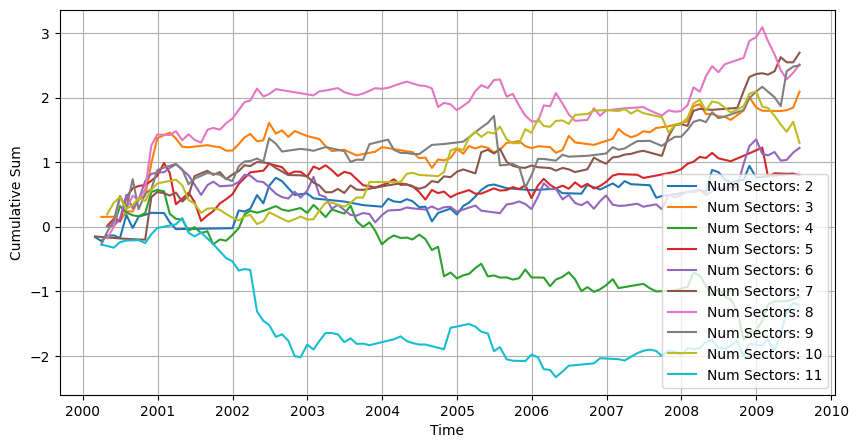

In [380]:
# def trading_M1(Price_DataFrame, Cap_DataFrame,Sector_Dict, months_to_run, Sector_order,cluster_method, num_clusters, n_market_cap, n_cv): 
all_results = []
for i in range(10):
    _a, _b, trading_results = trading_M1(train_df, caps_df, full_market_dict, 115, Sector_order, 'KMeans', int(i+2), 10, 4)
    all_results.append(trading_results)
cum_sum_plot_multiple(*all_results)

## M2

In [363]:
all_results = []
for i in range(7):
    _a, _b, trading_results = trading_M2(train_df, caps_df, full_market_dict, 115, Sector_order, 'KMeans', int(i+2), 10, 4)
    all_results.append(trading_results)
cum_sum_plot_multiple(*all_results)

KeyboardInterrupt: 

## M3

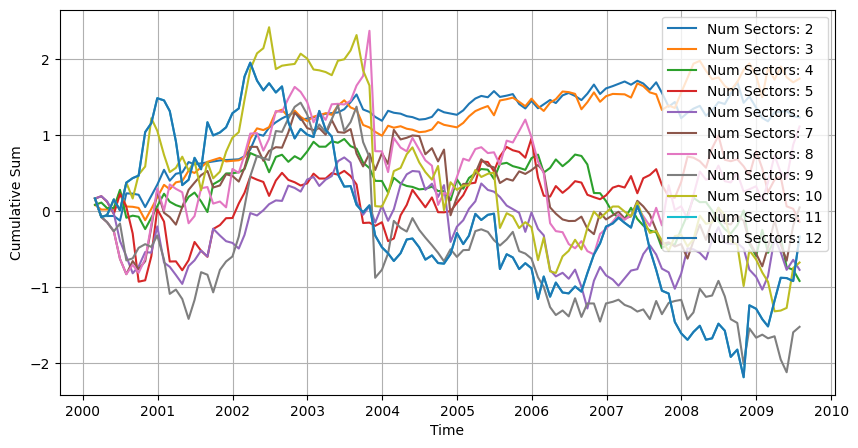

In [376]:
# def trading_M1(Price_DataFrame, Cap_DataFrame,Sector_Dict, months_to_run, Sector_order,cluster_method, num_clusters, n_market_cap, n_cv): 
all_results = []
for i in range(11):
    _a, _b, trading_results = trading_M3(train_df, caps_df, full_market_dict, 115, Sector_order, 'KMeans', int(i+2), 10, 4)
    all_results.append(trading_results)
cum_sum_plot_multiple(*all_results)

## Other testing

In [383]:
Sector_order

['Technology',
 'Health Care',
 'Energy',
 'Industrials',
 'Real Estate',
 'Consumer Staples',
 'Consumer Discretionary',
 'Telecommunications',
 'Finance',
 'Utilities',
 'Basic Materials']

In [402]:
Sector_order_1 = ['Technology',
 'Energy']
Sector_order_2 = ['Energy',
 'Technology']
res_1 , _b, trading_results_1 = trading_M1(train_df, caps_df, full_market_dict, 115, Sector_order_1, 'KMeans', 2, 10, 4)
res_1 , _b, trading_results_2 = trading_M1(train_df, caps_df, full_market_dict, 115, Sector_order_2, 'KMeans', 2, 10, 4)


ValueError: max() arg is an empty sequence

In [396]:
cum_sum_plot_single(trading_results_1)


,Cumulative_Sum
Time,
2000-02-29,0.083708
2000-03-31,-0.057371
2000-04-28,0.027784
2000-08-31,-0.171176
2000-11-30,0.154940
2001-01-31,0.291203
2001-03-30,0.323908
2001-04-30,0.126797
2001-08-31,0.159942


In [397]:
cum_sum_plot_single(trading_results_2)

,Cumulative_Sum
Time,
2000-02-29,0.083708
2000-03-31,-0.057371
2000-04-28,0.027784
2000-08-31,-0.171176
2000-11-30,0.154940
2001-01-31,0.291203
2001-03-30,0.323908
2001-04-30,0.126797
2001-08-31,0.159942
